In [1]:
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
%cd ~/cdv

/home/nmiklaucic/cdv


/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/home/nmiklaucic/miniconda3/envs/avid/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
clean = pd.read_pickle('precomputed/jarvis_dft3d_cleaned/dataframe.pkl')
clean

,space_group,formula,e_form,bandgap,atoms,e_total,ehull,dimensionality,density,num_atoms,num_spec,magmom
0,129,"(Ti, Cu, Si, As)",-0.42762,0.0,"[[2.67519992 2.67519992 7.37609819] Ti, [0.891...",-3.37474,0.0423,3D-bulk,5.956,8,4,0.000
1,221,"(Dy, B)",-0.41596,0.0,"[[0. 0. 0.] Dy, [0.81214866 2.04453946 2.04453...",-5.79186,0.0456,3D-bulk,5.522,7,2,0.000
2,119,"(Be, Os, Ru)",0.04847,0.0,"[[0. 0. 0.] Be, [1.83359072 0. 1.74248...",-4.65924,0.3183,intercalated ion,10.960,4,3,0.000
4,164,"(V, Se)",-0.71026,0.0,"[[0. 0. 0.] V, [ 1.67774838 -0.96865035 4.652...",-3.87823,0.0156,2D-bulk,5.718,3,2,0.000
5,62,"(Tb, Mn, Si)",-0.45468,0.0,"[[1.03935903 3.52971335 1.38135171] Tb, [3.118...",-4.35889,0.0817,3D-bulk,7.410,12,3,8.916
...,...,...,...,...,...,...,...,...,...,...,...,...
75980,164,"(Nd, Mg, Sb)",-0.69038,0.0,"[[0. 0. 0.] Nd, [2.3394364 1.35070495 2.69383...",-1.53096,0.0000,3D-bulk,5.116,5,3,0.000
75983,216,"(Yb, Pr, Pd)",-0.56635,0.0,"[[5.25036997 5.25036997 5.25036997] Yb, [1.750...",-1.70796,0.0000,3D-bulk,8.139,3,3,0.000
75984,216,"(Tb, Tl, Zn)",-0.29921,0.0,"[[1.66349368 1.66349368 1.66349368] Tb, [4.990...",0.05135,0.0000,3D-bulk,9.666,3,3,0.000
75989,216,"(Pr, Tl, Zn)",-0.34112,0.0,"[[1.71052992 1.71052992 1.71052992] Pr, [5.131...",-0.10696,0.0000,3D-bulk,8.517,3,3,0.000


In [11]:
import gemmi

crystal_systems = {
    num: gemmi.find_spacegroup_by_number(num).crystal_system_str()
    for num in range(1, 231)
}

clean['system'] = [crystal_systems[i] for i in clean.space_group]

In [15]:
sgs = jnp.array(clean['space_group'])

In [16]:
{v1: min(k for k, v in crystal_systems.items() if v == v1)
 for v1 in set(crystal_systems.values())}

{'orthorhombic': 16,
 'monoclinic': 3,
 'hexagonal': 168,
 'trigonal': 143,
 'cubic': 195,
 'triclinic': 1,
 'tetragonal': 75}

In [18]:
thresholds = jnp.array([3, 16, 75, 143, 168, 195])

(sgs[None, :] < thresholds[:, None]).sum(axis=0)

Array([3, 0, 3, ..., 0, 0, 3], dtype=int32)

In [12]:
clean['system'].value_counts()

system
cubic           15344
tetragonal      13586
orthorhombic     9642
monoclinic       7256
hexagonal        7181
trigonal         6615
triclinic        2162
Name: count, dtype: int64

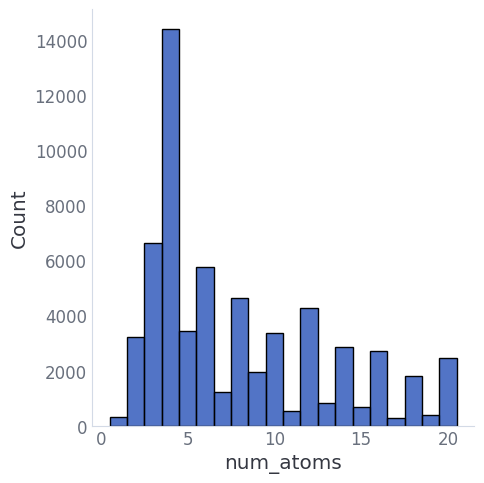

In [8]:
sns.displot(clean, x='num_atoms', discrete=True)

In [ ]:
elements = set()
for struct in clean['atoms']:
    elements.update(set(struct.elements))

print(' '.join([e.symbol for e in sorted(elements)]))
# print(elements)
# print({e.symbol: (e.average_ionic_radius, e.atomic_radius) for e in elements})

In [ ]:
cutoff = 7.0
max_num_neighbors = 20

graphs = []

def radius_graph(struct):
    graph_ijs = []
    graph_ims = []

    for i, nbs in enumerate(struct.get_all_neighbors(cutoff)):
        if nbs:
            sites, dists, idxs, ims = zip(*nbs)
            # select the first max_num_neighbors
            chosen = np.argsort(dists)[:max_num_neighbors]

            graph_ijs.append(np.vstack([np.ones_like(chosen) * i, np.array(idxs)[chosen]]))
            graph_ims.append(np.array(ims)[chosen])

    if graph_ijs:
        graph_ijs = np.concatenate(graph_ijs, axis=1).T.astype(np.uint16)
        graph_ims = np.concatenate(graph_ims).astype(np.int8)

        return graph_ijs, graph_ims
    else:
        # no atoms: return the empty list, filter it out later
        return np.array([]).astype(np.uint16), np.array([]).astype(np.int8)

In [ ]:
from multiprocessing import Pool
import warnings

warnings.simplefilter('ignore', category=UserWarning)

with Pool(processes=32) as P:
    graphs = P.map(radius_graph, clean['atoms'])

In [ ]:
# from pymatgen.core import Structure
# from pymatgen.analysis.graphs import StructureGraph
# from pymatgen.analysis.local_env import CrystalNN
# from tqdm import tqdm
# import warnings
# nn = CrystalNN()

# from multiprocessing import Pool

# warnings.simplefilter('ignore', category=UserWarning)

# with Pool(processes=48) as P:
#     graphs = P.map(nn.get_bonded_structure, clean['atoms'])

In [ ]:
import pickle

if 'graphs' in globals() or 'graphs' in locals():
    print('Saving...')
    with open('precomputed/jarvis_dft3d_cleaned/graphs.pkl', 'wb') as out:
        pickle.dump(graphs, out)
else:
    print('Loading...')
    with open('precomputed/jarvis_dft3d_cleaned/graphs.pkl', 'rb') as out:
        graphs = pickle.load(out)

We want to split the samples into batches. Because Jax needs fixed shapes, we're going to pad
batches to the same number of nodes and edges. This means that we want to sort into batches such
that the max number of edges in a batch is minimized, ideally just below a power of 2. That's what
the below code does.

It's also nice if the number of batches splits cleanly.

In [ ]:
from sympy import factorint
n_data = len(clean.index)
for power in range(1, 11):
    bs = 2 ** power - 1
    rem = n_data % bs
    factorstr = '\t'.join((f'{k}^{v}' for k, v in factorint(n_data - rem).items()))
    print(f'{bs:>4}\t{rem:>4}\t{factorstr}')

In [ ]:
batch_size = 62
max_in = 32
max_out = 20
max_nodes = 20

In [ ]:
from tqdm import tqdm
import functools as ft

graph_inds = []
graph_subs = []
for i, g in enumerate(graphs):
    if len(g[0]) == 0:
        continue

    node_in = max(np.unique(g[0][:, 1], return_counts=True)[1])
    node_out = max(np.unique(g[0][:, 0], return_counts=True)[1])
    if node_in <= max_in and node_out <= max_out:
        if np.max(g[0]) + 1 <= max_nodes:
            graph_inds.append(i)
            graph_subs.append(g)

        
if hasattr(graphs[0], 'graph'):
    # using networkx
    # each edge is split into 2 directed edges
    sizes = np.array([(len(g.graph.nodes), 2 * len(g.graph.edges)) for g in graphs[:-3]])
else:
    # using custom arrays
    sizes = np.array([(np.max(ijs) + 1, ijs.shape[0]) for ijs, ims in graph_subs])

def get_parts(numbers, batch, chunk_size):    
    # assert len(numbers) % (batch * chunk_size) == 0
    n_batches = len(numbers) // batch
    parts = np.zeros((batch, n_batches), dtype=jnp.int32)
    part_sizes = np.array([0 for _ in range(n_batches)])
    
    chunk_i = 0
    for sample_is in tqdm(np.argsort(-numbers).reshape(batch // chunk_size, chunk_size * n_batches)):
        sample_sizes = numbers[sample_is]
        n_filled = np.zeros((n_batches,), dtype=jnp.int32)
        for sample_i, sample_size in zip(sample_is, sample_sizes):
            next_i = np.argmin(part_sizes + 10000 * (n_filled == chunk_size))
            parts[chunk_i * chunk_size + n_filled[next_i], next_i] += sample_i
            n_filled[next_i] += 1
            part_sizes[next_i] += sample_size
        chunk_i += 1

    return parts, part_sizes

# TODO in the future we should probably pad instead of cutting, but at this point it's fine
num_remove = sizes.shape[0] % batch_size

parts, part_sizes = get_parts(sizes[:-num_remove, 1], batch_size, batch_size)
parts_orig_i = np.array(graph_inds)[parts]
print(part_sizes)

In [ ]:
len(sizes)

In [ ]:
np.unique(sizes[:, 0], return_counts=True)

In [ ]:
print(batch_size)
for ax in (0, 1):
    max_size = max(jnp.take(sizes[:, ax], parts).sum(axis=0))

    # pad to multiple of 64 for tensor cores
    pad_size = max_size + 16 - (max_size % 16)
    print(max_size, '\t', pad_size)

In [ ]:
jnp.save('precomputed/jarvis_dft3d_cleaned/batches.npy', parts_orig_i)

In [ ]:
recv = jnp.array([4, 1, 1, 2, 2, 3])
edge = jnp.array([0, 2, 3, 1, 1, 4])
nodes = jnp.array([4, 3, 2, 1, 0])

In [ ]:
jax.ops.segment_sum(recv, edge)

In [ ]:
'{:.4g}'.format(3.14159)

In [ ]:
np.array([0]).dtype.kind

In [2]:
from dataclasses import dataclass


@dataclass
class Bessel1DBasis:
    """Uses spherical Bessel functions with a cutoff, as in DimeNet++."""
    num_basis: int = 7
    cutoff: float = 7
    # Controls how fast the envelope goes to 0 at the cutoff.
    envelope_exp: int = 5

    def setup(self):
        def freq_init(rng):
            return jnp.arange(self.num_basis, dtype=jnp.float32) + 1
        self.freq = freq_init(None) 

    def __call__(self, x):
        dist = x[..., None] / self.cutoff
        env = 1

        # e(d) = sqrt(2/c) * sin(fπd/c)/d
        # we use sinc so it's defined at 0
        # jnp.sinc is sin(πx)/(πx)
        # e(d) = sqrt(2/c) * sin(πfd/c)/(fd/c) * f/c
        # e(d) = sqrt(2/c) * sinc(πfd/c)/(πfd/c) * πf/c

        e_d = jnp.sqrt(2 / self.cutoff) * jnp.sinc(self.freq * dist) * jnp.pi * self.freq / self.cutoff

        # debug_stat(dist=dist, env=env, freqs=freqs)
        return env * e_d
    
env = Bessel1DBasis(6)
env.setup()

NameError: name 'jnp' is not defined

In [1]:
xx = jnp.linspace(0, env.cutoff, 1000)
plt.plot(xx, env(xx))

NameError: name 'jnp' is not defined

In [ ]:
from pymatgen.core import Lattice

In [ ]:
from pymatgen.core import Lattice
lat = clean['atoms'].iloc[52338].lattice
lat

In [ ]:
Lattice.from_parameters(*[*lat.abc, *lat.angles])

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator as Interpolator
c = 1

da = jnp.mgrid[0.02:c:20j, 0:2*jnp.pi:40j]

fig, axs = plt.subplots(4, 4, figsize=(16, 16), sharex=True, sharey=True)

env = Bessel1DBasis(6, cutoff=c)
env.setup()

for row, l in enumerate(range(4)):
    for col, n in enumerate(range(1, 5)):


        dd, aa = da.reshape(2, -1)
        xx = dd * jnp.sin(aa)
        yy = dd * jnp.cos(aa)

        z_ln = jn_zeros(l, n)[-1]

        zz = env(dd)[:, n - 1] / env(dd * 0)[:, n - 1] * jnp.cos(aa * l)

        interp = Interpolator(list(zip(xx, yy)), zz)

        grid_xx, grid_yy = np.mgrid[-1:1:30j, -1:1:30j]
        grid_zz = interp(grid_xx, grid_yy)

        abs_max = np.nanmax(np.abs(grid_zz))

        axs[row][col].pcolormesh(grid_xx, grid_yy, grid_zz, shading='auto', cmap='rho_diverging', vmin=-1, vmax=1)
        axs[row][col].set_title(f'l = {l}, n = {n}, max {abs_max:.1f}')

In [ ]:
edge_ij = jnp.vstack((np.random.randint(0, 10, 15), np.random.randint(0, 10, 15)))
edge_ij

In [ ]:
np.where(edge_ij[1][:, None] == edge_ij[0][None, :])

In [5]:
from cdv.dataset import load_file
from cdv.config import MainConfig
from cdv.utils import debug_stat, debug_structure

conf = MainConfig()

batch = load_file(conf, 0)
debug_structure(batch);

arg0 >>> CrystalGraphs
├── nodes
│   ├── species
│   │   └── i16[512]
│   ├── frac
│   │   └── f32[512, 3]
│   ├── cart
│   │   └── f32[512, 3]
│   ├── incoming
│   │   └── i32[512, 32]
│   ├── incoming_pad
│   │   └── bool[512, 32]
│   ├── outgoing
│   │   └── i32[512, 20]
│   ├── outgoing_pad
│   │   └── bool[512, 20]
│   └── graph_i
│       └── i32[512]
├── edges
│   ├── to_jimage
│   │   └── i8[9872, 3]
│   ├── graph_i
│   │   └── i32[9872]
│   ├── sender
│   │   └── i32[9872]
│   └── receiver
│       └── i32[9872]
├── n_node
│   └── i32[64]
├── n_edge
│   └── i32[64]
├── padding_mask
│   └── bool[64]
└── graph_data
    ├── dataset_i
    │   └── i32[64]
    ├── abc
    │   └── f32[64, 3]
    ├── angles_rad
    │   └── f32[64, 3]
    ├── lat
    │   └── f32[64, 3, 3]
    ├── e_form
    │   └── f32[64]
    ├── bandgap
    │   └── f32[64]
    ├── e_total
    │   └── f32[64]
    ├── ehull
    │   └── f32[64]
    ├── dimensionality
    │   └── f32[64]
    ├── density
    │   └── f32[64]
    ├── space_group
    │   └── f32[64]
    ├── magmom
    │   └── f32[64]
    └── num_spec
        └── f32[64]

In [8]:
from cdv.gnn import InputEncoder, Bessel1DBasis, LearnedSpecEmb
from cdv.layers import Context
from flax import linen as nn

node_emb = 128

input_enc = InputEncoder(
    Bessel1DBasis(num_basis=7),
    nn.Dense(node_emb),
    LearnedSpecEmb(conf.data.num_species, node_emb)
)
ctx = Context(training=False)

g, params = input_enc.init_with_output(jax.random.key(0), cg=batch, ctx=ctx)

In [9]:
debug_structure(g);

arg0 >>> Graphs
├── node_emb
│   └── f32[512, 128]
├── incoming
│   └── i32[512, 32]
├── incoming_pad
│   └── bool[512, 32]
├── outgoing
│   └── i32[512, 20]
├── outgoing_pad
│   └── bool[512, 20]
├── carts
│   └── f32[512, 3]
├── dists
│   └── f32[9872]
├── vecs
│   └── f32[9872, 3]
├── senders
│   └── i32[9872]
├── receivers
│   └── i32[9872]
├── edge_emb
│   └── f32[9872, 128]
├── graph_emb
│   └── f32[64, 0]
├── n_nodes
│   └── i32[64]
├── n_edges
│   └── i32[64]
├── node_graph_i
│   └── i32[512]
├── edge_graph_i
│   └── i32[9872]
└── padding_mask
    └── bool[64]

In [14]:
jnp.split(g.node_graph_i, jnp.cumsum(g.n_nodes))


[
    Array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
    Array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32),
    Array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32),
    Array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32),
    Array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int32),
    Array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32),
    Array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32),
    Array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7], dtype=int32),
    Array([8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8], dtype=int32),
    Array([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype=int32),
    ... +55
]

In [16]:
carts0 = jnp.split(g.carts, jnp.cumsum(g.n_nodes))[0]
carts0


Array([[-0.26378998,  1.3603293 ,  3.785032  ],
       [ 2.1203477 ,  1.377736  ,  0.8357895 ],
       [ 2.674069  ,  0.9959503 ,  6.254862  ],
       [ 5.0582066 ,  1.013357  ,  3.3056192 ],
       [ 0.9661557 ,  1.0847164 ,  5.1100893 ],
       [ 1.0272698 ,  1.736202  ,  2.2607112 ],
       [ 3.7671468 ,  0.63748425,  4.82994   ],
       [ 3.828261  ,  1.2889699 ,  1.9805619 ],
       [ 5.24418   ,  2.6651103 ,  4.2230144 ],
       [ 5.2983813 , -0.8842216 ,  3.252501  ],
       [-0.32267967,  4.1740274 ,  0.6696388 ],
       [ 1.989725  , -0.8681227 ,  6.7803454 ],
       [ 2.8046918 ,  3.241809  ,  0.31030566],
       [-0.7672417 , -0.50225055,  7.098766  ],
       [-0.5039649 ,  3.2579079 ,  3.8381503 ],
       [-0.44976336, -0.29142416,  2.867637  ],
       [ 5.5616584 ,  2.8759367 , -0.00811461],
       [-1.8607508 ,  1.007663  ,  4.960875  ],
       [ 5.1170964 , -1.8003411 ,  6.4210124 ],
       [ 6.6551676 ,  1.3660233 ,  2.129776  ]], dtype=float32)

In [21]:
offsets = jnp.mgrid[-1:2, -1:2, -1:2].reshape(3, -1).T
offsets


Array([[-1, -1, -1],
       [-1, -1,  0],
       [-1, -1,  1],
       [-1,  0, -1],
       [-1,  0,  0],
       [-1,  0,  1],
       [-1,  1, -1],
       [-1,  1,  0],
       [-1,  1,  1],
       [ 0, -1, -1],
       [ 0, -1,  0],
       [ 0, -1,  1],
       [ 0,  0, -1],
       [ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  1, -1],
       [ 0,  1,  0],
       [ 0,  1,  1],
       [ 1, -1, -1],
       [ 1, -1,  0],
       [ 1, -1,  1],
       [ 1,  0, -1],
       [ 1,  0,  0],
       [ 1,  0,  1],
       [ 1,  1, -1],
       [ 1,  1,  0],
       [ 1,  1,  1]], dtype=int32)

In [29]:
from eins import EinsOp, Reductions as R
lat0 = batch.graph_data.lat[0]
offset_carts = carts0[None, :, :] + offsets[:, None, :] @ lat0.T
vecs = carts0[:, None, None, :] - offset_carts[None, :, :, :]
dists = R.l2_norm(vecs, axis=-1)
dists.shape

(20, 27, 20)

In [71]:
k = 10
dists_flat = dists.reshape(dists.shape[0], -1)
vals, inds = jax.lax.approx_min_k(dists_flat, k=k+1, reduction_dimension=-1)
vals = vals[..., 1:]
inds = inds[..., 1:]
ind_offsets = offsets[inds // dists.shape[-1]]
out_node_i = inds % dists.shape[-1]

out_node_i


Array([[ 4, 15, 14, 17,  5, 10, 16, 19, 13, 11],
       [ 5, 12,  7,  2, 11, 13, 12,  4, 10, 15],
       [ 6, 11,  4,  1, 12, 16, 11,  7, 18,  8],
       [ 7,  8,  9, 19,  6, 18, 13, 17, 16, 12],
       [ 0,  2, 11, 17,  6, 11, 14, 14,  5, 15],
       [ 1,  0, 10, 15, 14,  7,  4, 12, 10, 11],
       [ 2,  3, 18,  8,  9,  4,  7, 11, 18, 12],
       [ 3,  1, 12, 19,  5, 12,  9,  9,  6,  8],
       [18,  3,  6, 19, 13,  7,  9, 17, 16,  6],
       [16, 17,  3, 12,  6, 19,  7,  7, 19,  8],
       [15,  0,  5,  4,  5, 17, 12, 14, 13, 16],
       [ 2, 14,  1,  4, 13,  4,  6, 18,  5,  0],
       [ 1,  9,  2,  7, 16,  7,  5, 10,  6,  3],
       [14, 19, 11, 17,  8,  3,  4,  0, 17, 10],
       [13, 19,  0, 11,  5, 17,  4,  4, 17, 15],
       [10,  0,  5, 17, 16,  4, 14, 19, 13,  5],
       [ 9, 17, 12, 19, 15,  0,  7,  3, 19, 18],
       [ 9, 16,  0, 19,  4, 13, 15, 14, 14, 19],
       [ 8,  3,  6,  7,  6, 19, 11,  9, 16, 13],
       [14, 13,  3, 17,  7, 16,  8,  9,  9, 17]], dtype=int32)

In [78]:
graph_i = 0

to_jimage = ind_offsets.reshape(-1, 3)
edge_graph_i = jnp.zeros(to_jimage.shape[0]) + graph_i
sender = jnp.repeat(jnp.arange(dists.shape[-1]), k)
receiver = out_node_i.reshape(-1)

In [75]:
debug_structure(batch);

arg0 >>> CrystalGraphs
├── nodes
│   ├── species
│   │   └── i16[512]
│   ├── frac
│   │   └── f32[512, 3]
│   ├── cart
│   │   └── f32[512, 3]
│   ├── incoming
│   │   └── i32[512, 32]
│   ├── incoming_pad
│   │   └── bool[512, 32]
│   ├── outgoing
│   │   └── i32[512, 20]
│   ├── outgoing_pad
│   │   └── bool[512, 20]
│   └── graph_i
│       └── i32[512]
├── edges
│   ├── to_jimage
│   │   └── i8[9872, 3]
│   ├── graph_i
│   │   └── i32[9872]
│   ├── sender
│   │   └── i32[9872]
│   └── receiver
│       └── i32[9872]
├── n_node
│   └── i32[64]
├── n_edge
│   └── i32[64]
├── padding_mask
│   └── bool[64]
└── graph_data
    ├── dataset_i
    │   └── i32[64]
    ├── abc
    │   └── f32[64, 3]
    ├── angles_rad
    │   └── f32[64, 3]
    ├── lat
    │   └── f32[64, 3, 3]
    ├── e_form
    │   └── f32[64]
    ├── bandgap
    │   └── f32[64]
    ├── e_total
    │   └── f32[64]
    ├── ehull
    │   └── f32[64]
    ├── dimensionality
    │   └── f32[64]
    ├── density
    │   └── f32[64]
    ├── space_group
    │   └── f32[64]
    ├── magmom
    │   └── f32[64]
    └── num_spec
        └── f32[64]

In [63]:
vals


Array([[1.8287989 , 1.8985492 , 1.913455  , 2.014265  , 2.032651  ,
        2.1443985 , 2.8907363 , 3.121193  , 3.1654005 , 3.3116136 ,
        3.467528  , 3.4713855 , 3.5114207 , 3.7924194 , 3.8345141 ,
        3.8553658 , 4.198338  , 4.2264395 , 4.259158  , 4.2861705 ],
       [1.8313162 , 2.054076  , 2.0579967 , 2.4565287 , 2.7560284 ,
        3.3171554 , 3.3490388 , 3.4454691 , 3.4842832 , 3.6769512 ,
        3.7168849 , 3.7924194 , 3.8313618 , 3.8469987 , 3.8553658 ,
        4.115112  , 4.19968   , 4.2575245 , 4.3832817 , 4.408654  ],
       [1.8313165 , 2.054076  , 2.057997  , 2.4565284 , 2.7560282 ,
        3.3171551 , 3.3490388 , 3.445469  , 3.4842834 , 3.6769514 ,
        3.7168849 , 3.7924194 , 3.831362  , 3.8469987 , 3.8553658 ,
        4.115112  , 4.1996794 , 4.2575245 , 4.3832817 , 4.408654  ],
       [1.828799  , 1.8985491 , 1.9134551 , 2.0142653 , 2.0326507 ,
        2.1443985 , 2.8907366 , 3.121193  , 3.1654005 , 3.3116136 ,
        3.4675274 , 3.4713857 , 3.511421  , 